In [1]:
# Import libraries
import sys
import os

# Add the path to the folder containing the Python files
project_path = 'E:\FAO\crop_map\src'
if project_path not in sys.path:
    sys.path.insert(0, project_path)

import torch
from torch.optim import Adam
from data_utils import load_data, preprocess_data, prepare_data_for_1d_input, fill_missing_values
from model import DANWithPretrainedResNet1D
from train import train_model_with_mkmmd
from visualizations import plot_confusion_matrix, plot_training_loss, visualize_features
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier

# Set the device to CPU
device = torch.device('cpu')
print(f'Using device: {device}')


Using device: cpu


In [2]:
# Filepaths for the datasets
filepath_region_A = 'E:/FAO/crop_map/data/J23_feature.csv'
filepath_region_B = 'E:/FAO/crop_map/data/K23_feature.csv'

# Feature and label columns
feature_columns = ["B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B11", "B12", "NDVI", "NDWI"]
label_column = "class_code"
id_column = "fid"
date_column = "date"

# Load raw data
data_region_A = pd.read_csv(filepath_region_A)
data_region_B = pd.read_csv(filepath_region_B)

# Fill missing values
data_region_A_filled = fill_missing_values(
    data_region_A, 
    id_column=id_column, 
    date_column=date_column, 
    feature_columns=feature_columns
)
data_region_B_filled = fill_missing_values(
    data_region_B, 
    id_column=id_column, 
    date_column=date_column, 
    feature_columns=feature_columns
)

In [3]:
# Separate features and labels
X_source, y_source = load_data(data_region_A_filled, feature_columns, label_column)
X_target, y_target = load_data(data_region_B_filled, feature_columns, label_column)

# Reshape data for 1D input (num_channels=12, sequence_length=8)
# Prepare data for 1D CNN input
num_channels = 12  # Number of features per month
sequence_length = 8  # Number of months

X_source, y_source = prepare_data_for_1d_input(
    data_region_A_filled, 
    fid_column=id_column, 
    date_column=date_column, 
    feature_columns=feature_columns, 
    label_column=label_column, 
    num_channels=num_channels, 
    sequence_length=sequence_length
)

X_target, y_target = prepare_data_for_1d_input(
    data_region_B_filled, 
    fid_column=id_column, 
    date_column=date_column, 
    feature_columns=feature_columns, 
    label_column=label_column, 
    num_channels=num_channels, 
    sequence_length=sequence_length
)

In [4]:
# Preprocess data: normalize the features using the same scaler for source and target
X_source, scaler = preprocess_data(X_source)
X_target, _ = preprocess_data(X_target, scaler)

# Flatten the input data to combine the 8 months as features for each sample
# Ensure X_source and X_target are torch tensors before flattening
X_source_flat = torch.tensor(X_source, dtype=torch.float32).reshape(X_source.shape[0], -1)  # Shape becomes (n, 12 * 8)
X_target_flat = torch.tensor(X_target, dtype=torch.float32).reshape(X_target.shape[0], -1)  # Shape becomes (n, 12 * 8)

# Convert labels to torch tensors
y_source_flat = torch.tensor(y_source[:, -1], dtype=torch.long)
y_target_flat = torch.tensor(y_target[:, -1], dtype=torch.long)

X_source_tensor = X_source_flat.to(device)
y_source_tensor = y_source_flat.to(device)
X_target_tensor = X_target_flat.to(device)
y_target_tensor = y_target_flat.to(device)

In [5]:
# Initialize the model
num_classes = 14  # Assuming all classes are present in the source data
model = DANWithPretrainedResNet1D(input_channels=num_channels, num_classes=num_classes, dropout_rate=0.5, use_batch_norm=True)

# Move the model to the CPU
model = model.to(device)

In [6]:
# Set up the optimizer
optimizer = Adam(model.parameters(), lr=0.001)

# Set up the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

In [7]:
# Train the model using the MK-MMD loss for domain adaptation
y_source_tensor = y_source_tensor - 1
y_target_tensor = y_target_tensor - 1
# Reshape the input tensors to (batch_size, num_channels, sequence_length)
X_source_tensor = X_source_tensor.view(X_source_tensor.shape[0], 12, 8)  # Shape becomes (n, 12, 8)
X_target_tensor = X_target_tensor.view(X_target_tensor.shape[0], 12, 8)  # Shape becomes (n, 12, 8)

model = train_model_with_mkmmd(
    model,
    X_source_tensor,
    y_source_tensor,
    X_target_tensor,
    y_target_tensor,
    optimizer,
    lambda_mmd=0.1,  # Weight for the MK-MMD loss
    num_epochs=1000,  # Number of training epochs
    early_stopping_patience=100,  # Early stopping patience
    lr_scheduler=scheduler  # Learning rate scheduler
)

# Load the best model weights
#model.load_state_dict(torch.load('best_model.pth'))

Epoch [0/1000], Source Loss: 2.6726, Target Loss: 2.7015, MMD Loss: 1.9337, Total Loss: 5.5675
Epoch [100/1000], Source Loss: 0.9042, Target Loss: 0.8998, MMD Loss: 0.0000, Total Loss: 1.8041
Epoch [200/1000], Source Loss: 1.1616, Target Loss: 1.0182, MMD Loss: 0.0000, Total Loss: 2.1797
Early stopping at epoch 200 with best loss: 1.8041


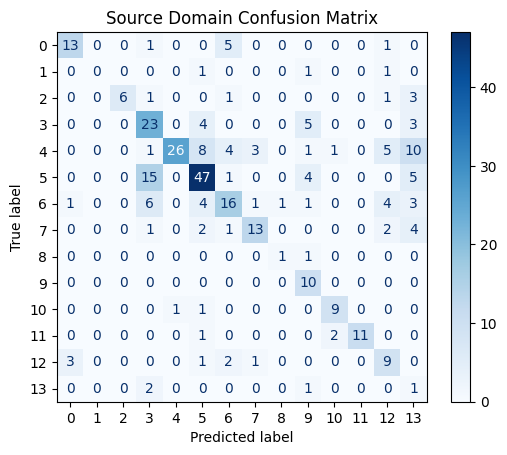

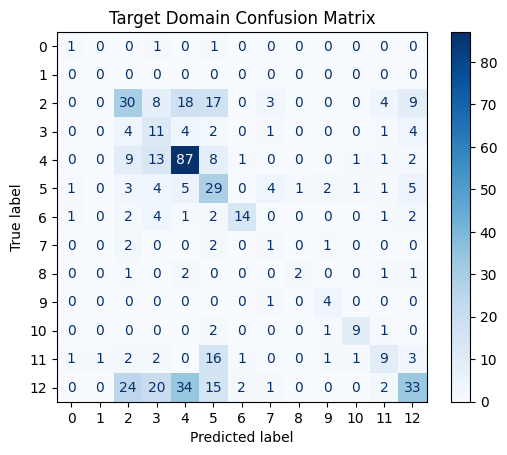

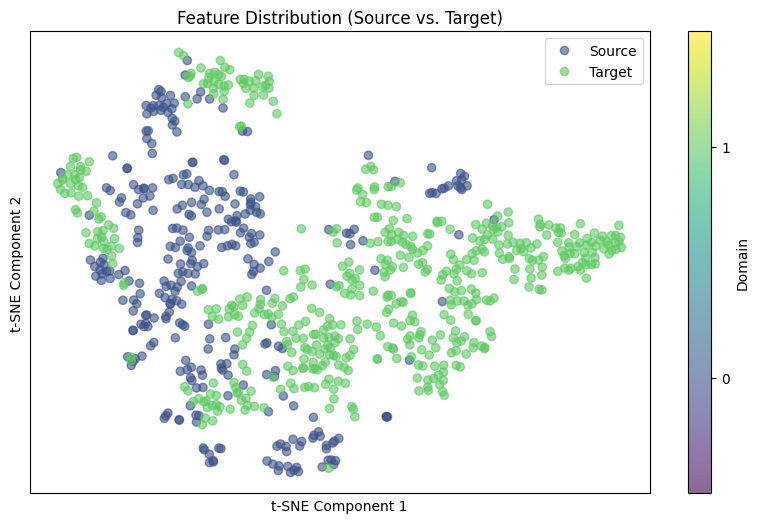

In [8]:
# Set the model to evaluation mode
model.eval()
with torch.no_grad():
    # Get predictions for source and target data
    source_predictions = model(X_source_tensor).argmax(dim=1).cpu().numpy()
    target_predictions = model(X_target_tensor).argmax(dim=1).cpu().numpy()

# Use the correct labels with shape (n,)
y_source_eval = y_source_tensor.cpu().numpy()  # Shape becomes (n,)
y_target_eval = y_target_tensor.cpu().numpy()  # Shape becomes (n,)

# Plot confusion matrices for source and target domains
plot_confusion_matrix(y_source_eval, source_predictions, title='Source Domain Confusion Matrix')
plot_confusion_matrix(y_target_eval, target_predictions, title='Target Domain Confusion Matrix')

# Visualize feature distributions using t-SNE
visualize_features(X_source_tensor.cpu(), X_target_tensor.cpu(), title='Feature Distribution (Source vs. Target)')


In [7]:
# Adjust labels to be zero-indexed
y_source_tensor = y_source_tensor - 1
y_target_tensor = y_target_tensor - 1

# Reshape the input tensors to (batch_size, num_channels, sequence_length)
X_source_tensor = X_source_tensor.view(X_source_tensor.shape[0], 12, 8)  # Shape becomes (318, 12, 8)
X_target_tensor = X_target_tensor.view(X_target_tensor.shape[0], 12, 8)  # Shape becomes (318, 12, 8)

# Step 1: Split the source dataset into 90% training and 10% validation
X_source_train, X_source_val, y_source_train, y_source_val = train_test_split(
    X_source_tensor, y_source_tensor, test_size=0.1, random_state=42
)

# Step 2: Train the model on the training set
model = DANWithPretrainedResNet1D(input_channels=num_channels, num_classes=num_classes, dropout_rate=0.5, use_batch_norm=True)
model = model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

# Train using the MK-MMD loss function with the training set
model = train_model_with_mkmmd(
    model,
    X_source_train,
    y_source_train,
    X_target_tensor,  # Use the reshaped target data for domain adaptation
    y_target_tensor,
    optimizer,
    lambda_mmd=10,  # Weight for the MK-MMD loss
    num_epochs=1000,  # Number of training epochs
    early_stopping_patience=100,  # Early stopping patience
    lr_scheduler=scheduler  # Learning rate scheduler
)

# Step 3: Evaluate the model on the validation set and target dataset
model.eval()
with torch.no_grad():
    # Get predictions for the validation set
    val_predictions = model(X_source_val).argmax(dim=1).cpu().numpy()
    y_val_eval = y_source_val.cpu().numpy()

    # Get predictions for the target dataset
    target_predictions = model(X_target_tensor).argmax(dim=1).cpu().numpy()
    y_target_eval = y_target_tensor.cpu().numpy()

# Step 4: Compute metrics for the validation set
val_accuracy = accuracy_score(y_val_eval, val_predictions)
val_precision = precision_score(y_val_eval, val_predictions, average='weighted', zero_division=0)
val_recall = recall_score(y_val_eval, val_predictions, average='weighted', zero_division=0)
val_f1 = f1_score(y_val_eval, val_predictions, average='weighted')

# Compute metrics for the target dataset
target_accuracy = accuracy_score(y_target_eval, target_predictions)
target_precision = precision_score(y_target_eval, target_predictions, average='weighted', zero_division=0)
target_recall = recall_score(y_target_eval, target_predictions, average='weighted', zero_division=0)
target_f1 = f1_score(y_target_eval, target_predictions, average='weighted')

# Display the metrics
print(f"Validation Set Metrics:\n Accuracy: {val_accuracy:.4f}\n Precision: {val_precision:.4f}\n Recall: {val_recall:.4f}\n F1-score: {val_f1:.4f}")
print(f"Target Set Metrics:\n Accuracy: {target_accuracy:.4f}\n Precision: {target_precision:.4f}\n Recall: {target_recall:.4f}\n F1-score: {target_f1:.4f}")


Epoch [0/1000], Source Loss: 2.6879, Target Loss: 2.6913, MMD Loss: 1.9863, Total Loss: 25.2421
Epoch [100/1000], Source Loss: 0.9425, Target Loss: 0.9725, MMD Loss: 0.0000, Total Loss: 1.9149
Epoch [200/1000], Source Loss: 1.0454, Target Loss: 1.0386, MMD Loss: 0.0000, Total Loss: 2.0841
Epoch [300/1000], Source Loss: 1.0897, Target Loss: 0.9913, MMD Loss: 0.0000, Total Loss: 2.0810
Early stopping at epoch 335 with best loss: 1.7901
Validation Set Metrics:
 Accuracy: 0.1875
 Precision: 0.2528
 Recall: 0.1875
 F1-score: 0.1972
Target Set Metrics:
 Accuracy: 0.4149
 Precision: 0.4406
 Recall: 0.4149
 F1-score: 0.4169


In [ ]:
# Adjust labels to be zero-indexed
y_source_tensor = y_source_tensor - 1
y_target_tensor = y_target_tensor - 1

# Reshape the input tensors to (batch_size, num_channels, sequence_length)
X_source_tensor = X_source_tensor.view(X_source_tensor.shape[0], 12, 8)  # Shape becomes (318, 12, 8)
X_target_tensor = X_target_tensor.view(X_target_tensor.shape[0], 12, 8)  # Shape becomes (318, 12, 8)

# Step 1: Split the target dataset into 30% training and 70% test
X_target_train, X_target_test, y_target_train, y_target_test = train_test_split(
    X_target_tensor, y_target_tensor, test_size=0.70, random_state=42
)

# Step 2: Train the model on the training set
model = DANWithPretrainedResNet1D(input_channels=num_channels, num_classes=num_classes, dropout_rate=0.5, use_batch_norm=True)
model = model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

# Train using the MK-MMD loss function with the training set
model = train_model_with_mkmmd(
    model,
    X_source_tensor,
    y_source_tensor,
    X_target_train,  # Use the reshaped target data for domain adaptation
    y_target_train,
    optimizer,
    lambda_mmd=10,  # Weight for the MK-MMD loss
    num_epochs=1000,  # Number of training epochs
    early_stopping_patience=100,  # Early stopping patience
    lr_scheduler=scheduler  # Learning rate scheduler
)

# Step 3: Evaluate the model on the target dataset
model.eval()
with torch.no_grad():
    # Get predictions for the target dataset
    target_test_predictions = model(X_target_test).argmax(dim=1).cpu().numpy()
    y_target_eval = y_target_test.cpu().numpy()

# Compute metrics for the target dataset
target_accuracy = accuracy_score(y_target_eval, target_predictions)
target_precision = precision_score(y_target_eval, target_predictions, average='weighted', zero_division=0)
target_recall = recall_score(y_target_eval, target_predictions, average='weighted', zero_division=0)
target_f1 = f1_score(y_target_eval, target_predictions, average='weighted')

# Display the metrics
print(f"Test Set Metrics:\n Accuracy: {target_accuracy:.4f}\n Precision: {target_precision:.4f}\n Recall: {target_recall:.4f}\n F1-score: {target_f1:.4f}")


In [17]:
# Split the source dataset into 90% training and 10% validation
X_source_train, X_source_val, y_source_train, y_source_val = train_test_split(
    X_source_flat.cpu().numpy(), y_source_flat.cpu().numpy(), test_size=0.1, random_state=42
)

# Flatten the target features for the Random Forest input
X_target_flat = X_target_tensor.view(X_target_tensor.shape[0], -1).cpu().numpy()  # Shape becomes (318, 12 * 8)

# Train the Random Forest model on the training set
rf_model = RandomForestClassifier(n_estimators=500, random_state=42)
rf_model.fit(X_source_train, y_source_train)

# Evaluate the model on the validation set and target dataset
# Get predictions for the validation set
val_predictions = rf_model.predict(X_source_val)
# Get predictions for the target dataset
target_predictions = rf_model.predict(X_target_flat)

# Compute metrics for the validation set
val_accuracy = accuracy_score(y_source_val, val_predictions)
val_precision = precision_score(y_source_val, val_predictions, average='weighted', zero_division=0)
val_recall = recall_score(y_source_val, val_predictions, average='weighted', zero_division=0)
val_f1 = f1_score(y_source_val, val_predictions, average='weighted')

# Compute metrics for the target dataset
target_accuracy = accuracy_score(y_target_flat.cpu().numpy(), target_predictions)
target_precision = precision_score(y_target_flat.cpu().numpy(), target_predictions, average='weighted', zero_division=0)
target_recall = recall_score(y_target_flat.cpu().numpy(), target_predictions, average='weighted', zero_division=0)
target_f1 = f1_score(y_target_flat.cpu().numpy(), target_predictions, average='weighted')

# Display the metrics
print(f"Validation Set Metrics (Random Forest):\n Accuracy: {val_accuracy:.4f}\n Precision: {val_precision:.4f}\n Recall: {val_recall:.4f}\n F1-score: {val_f1:.4f}")
print(f"Target Set Metrics (Random Forest):\n Accuracy: {target_accuracy:.4f}\n Precision: {target_precision:.4f}\n Recall: {target_recall:.4f}\n F1-score: {target_f1:.4f}")


Validation Set Metrics (Random Forest):
 Accuracy: 0.6562
 Precision: 0.6990
 Recall: 0.6562
 F1-score: 0.6323
Target Set Metrics (Random Forest):
 Accuracy: 0.2103
 Precision: 0.2461
 Recall: 0.2103
 F1-score: 0.1836
